In [20]:
import os #for using operating system-dependent functionality
import numpy as np # for numerical computations
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt #for creating visualizations 
import seaborn as sns #for high-level interfaces, built on-top plt
import warnings
warnings.filterwarnings(action="ignore")

import librosa #for audio analysis
import librosa.display #for displaying audio data

from sklearn.preprocessing import MinMaxScaler #for feature scaling
from tqdm import tqdm, notebook,trange #functions/classes for displaying progress bars during iterations
from sklearn.linear_model import LogisticRegression # for logistic regression modeling

from sklearn.metrics import accuracy_score as acc_score #evaluation metrics
from sklearn.metrics import recall_score as rec_score
from sklearn.metrics import precision_score as prec_score
from sklearn.metrics import f1_score as f_scores
from sklearn.metrics import confusion_matrix

from keras import backend as K #pre-trained deep learning models for computer vision tasks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential #to build sequential neural network models
from keras.layers import Flatten,BatchNormalization #DL layers
from keras.layers import Dense,Dropout
from keras.optimizers import Adam # optimizer used in training
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import plotly as px #for creating interactive visualizations
import plotly.graph_objects as go #for creating graph objects

from pylab import rcParams #to customize graph figure
rcParams['figure.figsize'] = 15,6
plt.style.use('fivethirtyeight')

In [21]:
#importing all 380,000 data entries to one file for treatment
file_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test.csv",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test.csv",
]
dfs = []
for i in file_paths:
    df = pd.read_csv(i)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

output_file_path = os.path.join("D:/AMINA/PFE24/application", "data.csv")
df.to_csv(output_file_path, index=False)

df.head(2)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN


In [22]:
#DATA CLEANING
#removing all lines without age, gender, and accent values + deleting unecessary columns
df = df.dropna(subset=['age'])
df = df[["filename","age","gender","accent"]]
df = df.dropna(subset=['gender'])
df = df.dropna(subset=['accent'])
cleanup_nums = {"age": {"teens":1,"twenties":2,"thirties":3,"fourties":4,"fifties":5,"sixties":6,"seventies":7,"eighties":8}}
df = df.replace(cleanup_nums)
df.head(2)

,filename,age,gender,accent
5,cv-valid-train/sample-000005.mp3,2,female,us
8,cv-valid-train/sample-000008.mp3,7,male,us


In [23]:
print("Dataset Count:", len(df. index))
print(df['age'].value_counts())

Dataset Count: 126108
age
2    36631
3    32695
4    19082
5    17895
6     8486
1     8039
7     2830
8      450
Name: count, dtype: int64


In [24]:
#AUDIO PROCESSING

#first: iterating through the audio folders and comparing with df["filename"] values
folder_paths = [
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-train/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-test/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-valid-dev/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-train/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-test/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-other-dev/",
    "D:/AMINA/PFE24/datasets/commonvoice/cv-invalid/"
]

for folder_path in folder_paths:
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if the filename starts with the folder name
        if row["filename"].startswith(folder_path.split("/")[-2]):
            # Concatenate the folder path with the filename
            df.at[index, "filename"] = folder_path + row["filename"]
# Reset the index because it was ruined after combining the 7 csv and deleting multiple lin
df.reset_index(drop=True, inplace=True)
df.head(2)

,filename,age,gender,accent
0,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,2,female,us
1,D:/AMINA/PFE24/datasets/commonvoice/cv-valid-t...,7,male,us


11433


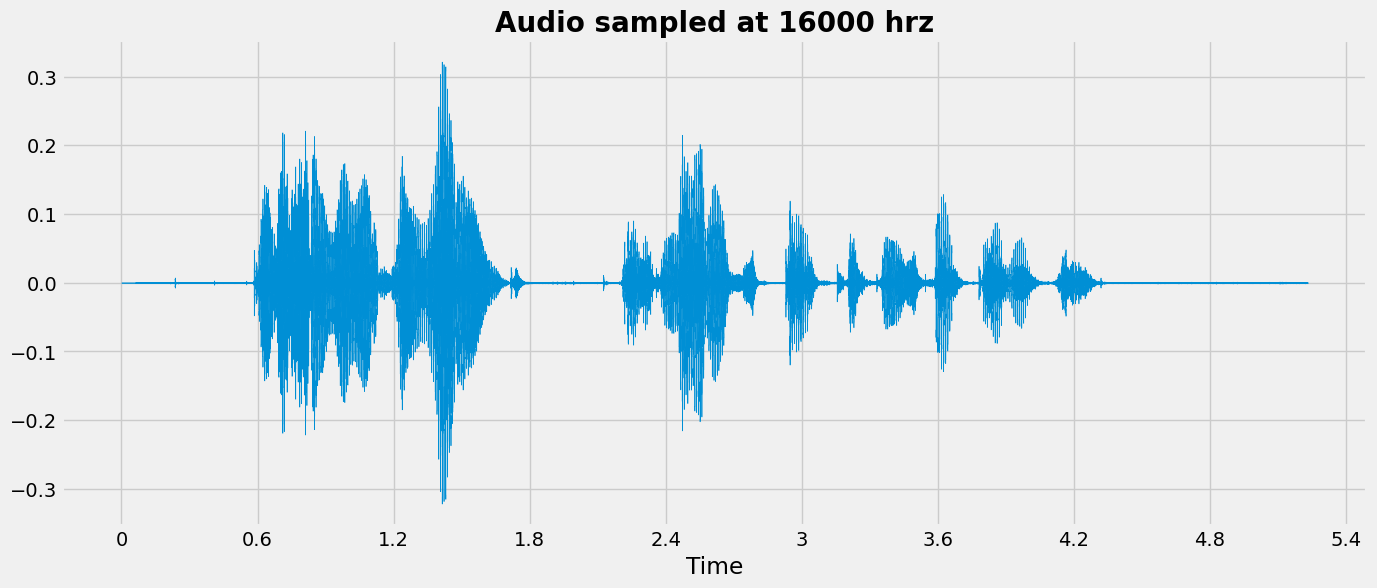

In [25]:
sample_rate = 16000 #16,000 Hz
idx = np.random.randint(0,len(df))
fl = df.filename[idx]
print(idx)
audio_array, sampling_rate = librosa.load(fl, sr=sample_rate)
plt.figure()
librosa.display.waveshow(audio_array, sr=sampling_rate)
plt.title('Audio sampled at {} hrz'.format(sample_rate),fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.show()

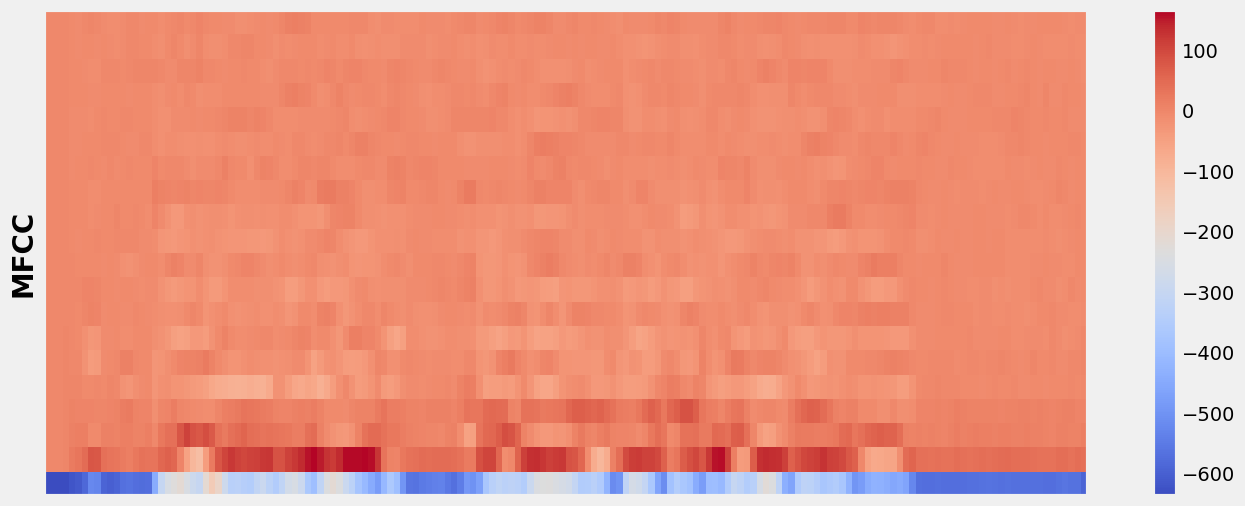

In [26]:
#Creating the MFCC for the audio
audio_array,sampling_rate = librosa.load(fl, sr=sample_rate) 
mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc = 20) #10 components
librosa.display.specshow(mfcc)
plt.ylabel('MFCC',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.show() 

In [29]:
import time
# CHANGING THE AUDIO CLIPS TO MFCC IMAGES
output_folder = "D:/AMINA/PFE24/application/audio_imgs" # where the MFCC graph images will be saved.

# Define the interval for printing progress
print_interval = 1000
batch_start_time = time.time()

# Determine the maximum index from existing files in the output folder
existing_files = os.listdir(output_folder)
existing_indices = [int(filename.split('_')[0]) for filename in existing_files if filename.endswith('_mfcc.png')]
max_index_processed = max(existing_indices, default=-1)

for index, row in df.iloc[max_index_processed + 1:].iterrows():
    audio_path = row['filename']#Retrieves the filename (path to the audio clip)
    gender = row['gender']# Retrieves the gender info
    accent = row['accent']# Retrieves the accent info

    audio_array, sampling_rate = librosa.load(audio_path, sr=sample_rate)
    #Loads the audio clip from the specified audio_path and returns the audio waveform as an array
    mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=20)
    #Computes the MFCC for the loaded audio_array with 16GHz and 20 components

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')

    # Extracts the filename of the audio clip (excluding the directory path)
    audio_clip_filename = os.path.basename(audio_path)
    
    # Saves the MFCC image with a unique name that combines:
    # the output folder + the index of the current row + the audio clip filename + the suffix "_mfcc.png".
    img_filename = os.path.join(output_folder, f'{index}_{audio_clip_filename}_mfcc.png')
    plt.savefig(img_filename)
    plt.close()

    # Print progress at intervals
    if index % print_interval == 0 and index != 0:
        batch_end_time = time.time()
        batch_processing_time = batch_end_time - batch_start_time
        print(f"Processed {index} rows out of {len(df)} in {batch_processing_time:.2f} seconds")
        batch_start_time = time.time()  # Reset the batch start time for the next interval

Processed 0 rows out of 126108
Processed 1000 rows out of 126108
Processed 2000 rows out of 126108
Processed 3000 rows out of 126108
Processed 4000 rows out of 126108
Processed 5000 rows out of 126108
Processed 6000 rows out of 126108
Processed 7000 rows out of 126108
Processed 8000 rows out of 126108
Processed 9000 rows out of 126108
Processed 10000 rows out of 126108
Processed 11000 rows out of 126108
Processed 12000 rows out of 126108
Processed 13000 rows out of 126108
Processed 14000 rows out of 126108
Processed 15000 rows out of 126108
Processed 16000 rows out of 126108
Processed 17000 rows out of 126108
Processed 18000 rows out of 126108


In [28]:
# Define your CNN architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

NameError: name 'input_shape' is not defined